In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

/opt/conda/envs/laps/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [5]:
%config InlineBackend.figure_format = 'retina'

In [62]:
EXPERIMENT_NAME = "runs_re2"
DOMAIN = "re2"

# EXPERIMENT_NAME = "runs_clevr"
# DOMAIN = "clevr"

# EXPERIMENT_NAME = "runs_logo"
# DOMAIN = "logo"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [63]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch_namer"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_re2
Available domains: ['re2']


## Runtime metrics

In [64]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime

Not found: ../experiments_iterative/outputs/runs_re2/domains/re2/baseline_dreamcoder/seed_222/baseline_dreamcoder_96/6/metrics.json
Not found: ../experiments_iterative/outputs/runs_re2/domains/re2/baseline_dreamcoder/seed_222/baseline_dreamcoder_96/7/metrics.json
Not found: ../experiments_iterative/outputs/runs_re2/domains/re2/baseline_dreamcoder/seed_222/baseline_dreamcoder_96/8/metrics.json
Not found: ../experiments_iterative/outputs/runs_re2/domains/re2/baseline_dreamcoder/seed_222/baseline_dreamcoder_96/9/metrics.json
Not found: ../experiments_iterative/outputs/runs_re2/domains/re2/baseline_dreamcoder/seed_333/baseline_dreamcoder_96/0/metrics.json
Not found: ../experiments_iterative/outputs/runs_re2/domains/re2/baseline_dreamcoder/seed_333/baseline_dreamcoder_96/1/metrics.json
Not found: ../experiments_iterative/outputs/runs_re2/domains/re2/baseline_dreamcoder/seed_333/baseline_dreamcoder_96/2/metrics.json
Not found: ../experiments_iterative/outputs/runs_re2/domains/re2/baseline_dr

,curr_iteration,model_type,model_fn,task_split,time_start,time_end,time_elapsed,domain,experiment_type,seed,iteration
0,0,grammar,infer_programs_for_tasks,train,2023-04-28 22:03:45.337438208+00:00,2023-04-28 22:20:25.191762176+00:00,999.854324,re2,baseline_dreamcoder,111,0
1,0,amortized_synthesis,optimize_model_for_frontiers,train,2023-04-28 22:20:25.195506432+00:00,2023-04-28 22:24:19.571212288+00:00,234.375706,re2,baseline_dreamcoder,111,0
2,0,amortized_synthesis,infer_programs_for_tasks,train,2023-04-28 22:24:19.571785472+00:00,2023-04-28 22:41:05.207317504+00:00,1005.635532,re2,baseline_dreamcoder,111,0
3,0,amortized_synthesis,infer_programs_for_tasks,test,2023-04-28 22:41:05.210528768+00:00,2023-04-29 00:08:40.567719168+00:00,5255.357190,re2,baseline_dreamcoder,111,0
4,1,amortized_synthesis,optimize_model_for_frontiers,train,2023-04-29 00:08:42.334964224+00:00,2023-04-29 00:13:29.895579648+00:00,287.560615,re2,baseline_dreamcoder,111,1
...,...,...,...,...,...,...,...,...,...,...,...
135,8,llm_solver,infer_programs_for_tasks,train,2023-04-28 17:06:01.251264768+00:00,2023-04-28 17:13:15.705343232+00:00,434.454078,re2,gpt_solver_stitch_namer,333,8
136,8,library_namer,generate_library_names,train,2023-04-28 17:13:20.114536960+00:00,2023-04-28 17:13:40.493814528+00:00,20.379277,re2,gpt_solver_stitch_namer,333,8
137,9,llm_solver,infer_programs_for_tasks,train,2023-04-28 17:13:41.173467136+00:00,2023-04-28 17:22:25.893033216+00:00,524.719566,re2,gpt_solver_stitch_namer,333,9
138,9,llm_solver,infer_programs_for_tasks,test,2023-04-28 17:22:25.893386496+00:00,2023-04-28 18:09:50.464889344+00:00,2844.571503,re2,gpt_solver_stitch_namer,333,9


In [65]:
df_runtime.groupby(["domain", "experiment_type", "model_type", "model_fn", "task_split"]).time_elapsed.agg("mean")

domain  experiment_type          model_type           model_fn                      task_split
re2     baseline_dreamcoder      amortized_synthesis  infer_programs_for_tasks      test          4414.430210
                                                                                    train         1018.210660
                                                      optimize_model_for_frontiers  train          257.151624
                                 grammar              infer_programs_for_tasks      train         1000.311152
        gpt_solver               llm_solver           infer_programs_for_tasks      test          5892.600588
                                                                                    train          999.823117
        gpt_solver_stitch_namer  library_namer        generate_library_names        train           23.105214
                                 llm_solver           infer_programs_for_tasks      test          3125.464148
                         

In [66]:
df_infer_time = df_runtime.query("model_fn == 'infer_programs_for_tasks'").groupby(["domain", "experiment_type", "model_type", "model_fn", "task_split"])
df_infer_time

<AxesSubplot:xlabel='time_elapsed', ylabel='experiment_type'>

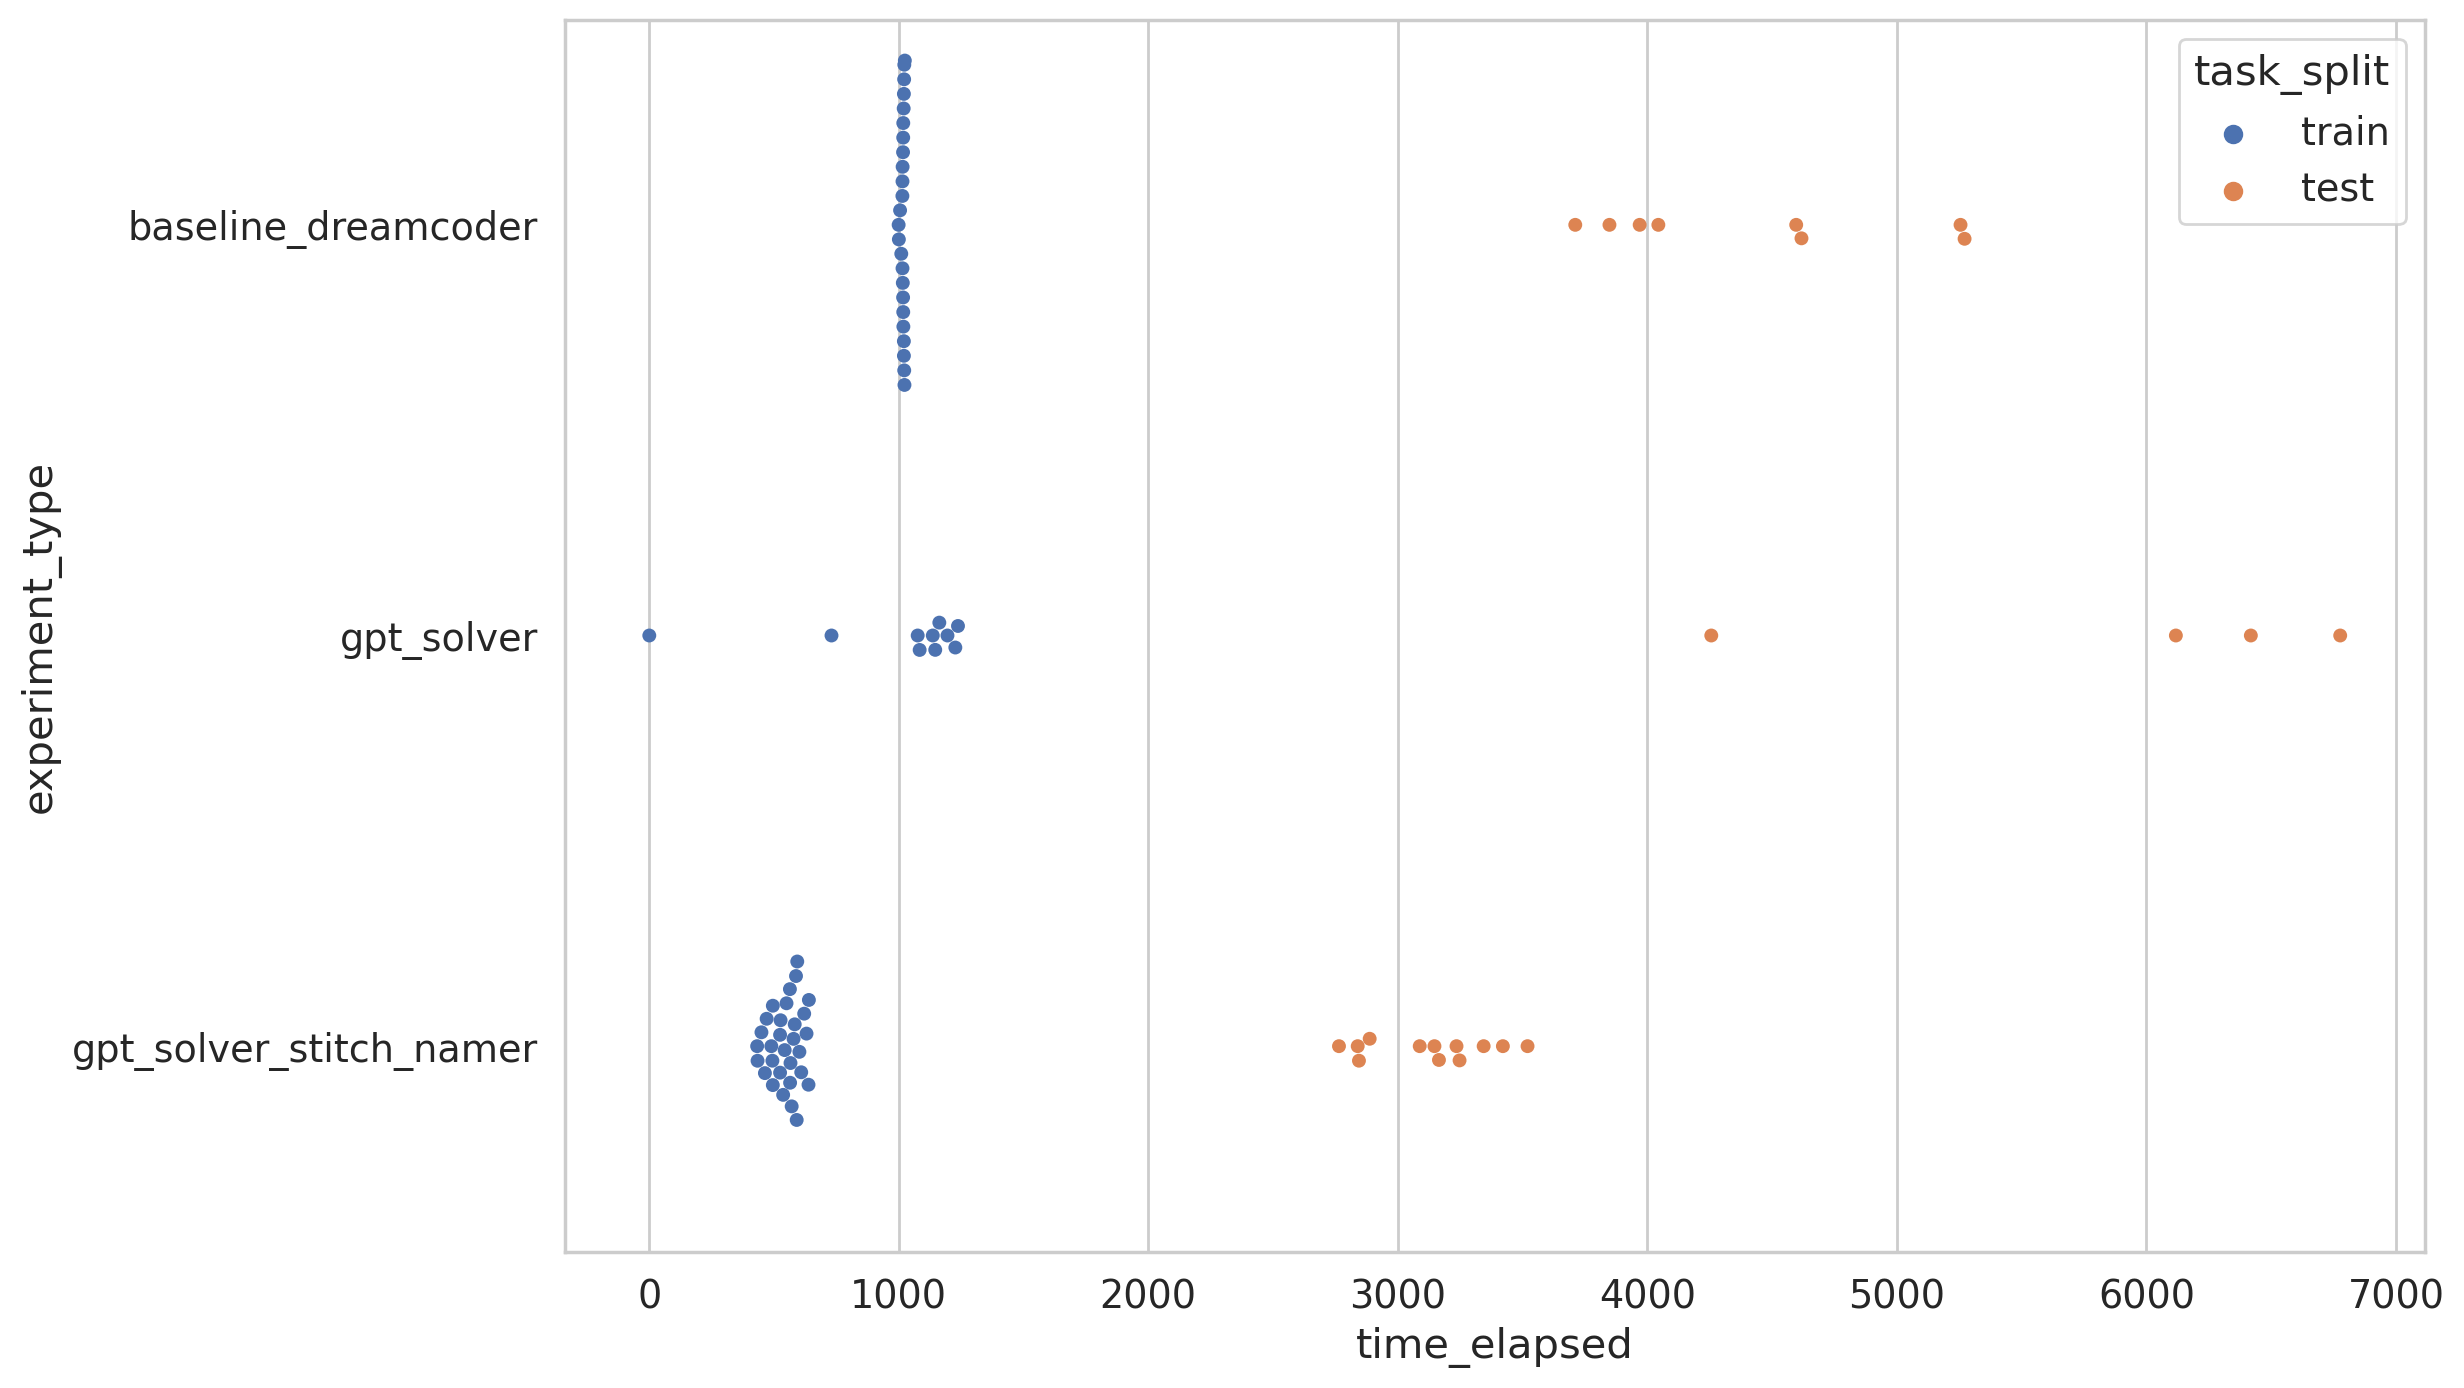

In [69]:
sns.swarmplot(data=df_runtime.query("model_fn == 'infer_programs_for_tasks'"), y="experiment_type", x="time_elapsed", hue="task_split")

# Analysis 1: Tasks solved over time

### Tasks solved vs. LAPS iteration

In [33]:
df_results = analyzer.get_synthesis_summary_for_domain(
    DOMAIN,
)
df_results

,experiment_type,seed,iteration,split,n_solved,percent_solved
0,baseline_dreamcoder,111,0,test,43,0.417476
1,baseline_dreamcoder,111,0,train,41,0.214660
2,baseline_dreamcoder,111,1,train,97,0.507853
3,baseline_dreamcoder,111,2,train,127,0.664921
4,baseline_dreamcoder,111,3,test,86,0.834951
...,...,...,...,...,...,...
93,gpt_solver_stitch_namer,333,6,train,176,0.921466
94,gpt_solver_stitch_namer,333,7,train,181,0.947644
95,gpt_solver_stitch_namer,333,8,train,183,0.958115
96,gpt_solver_stitch_namer,333,9,test,94,0.912621


Text(0.5, 1.025, 'clevr')

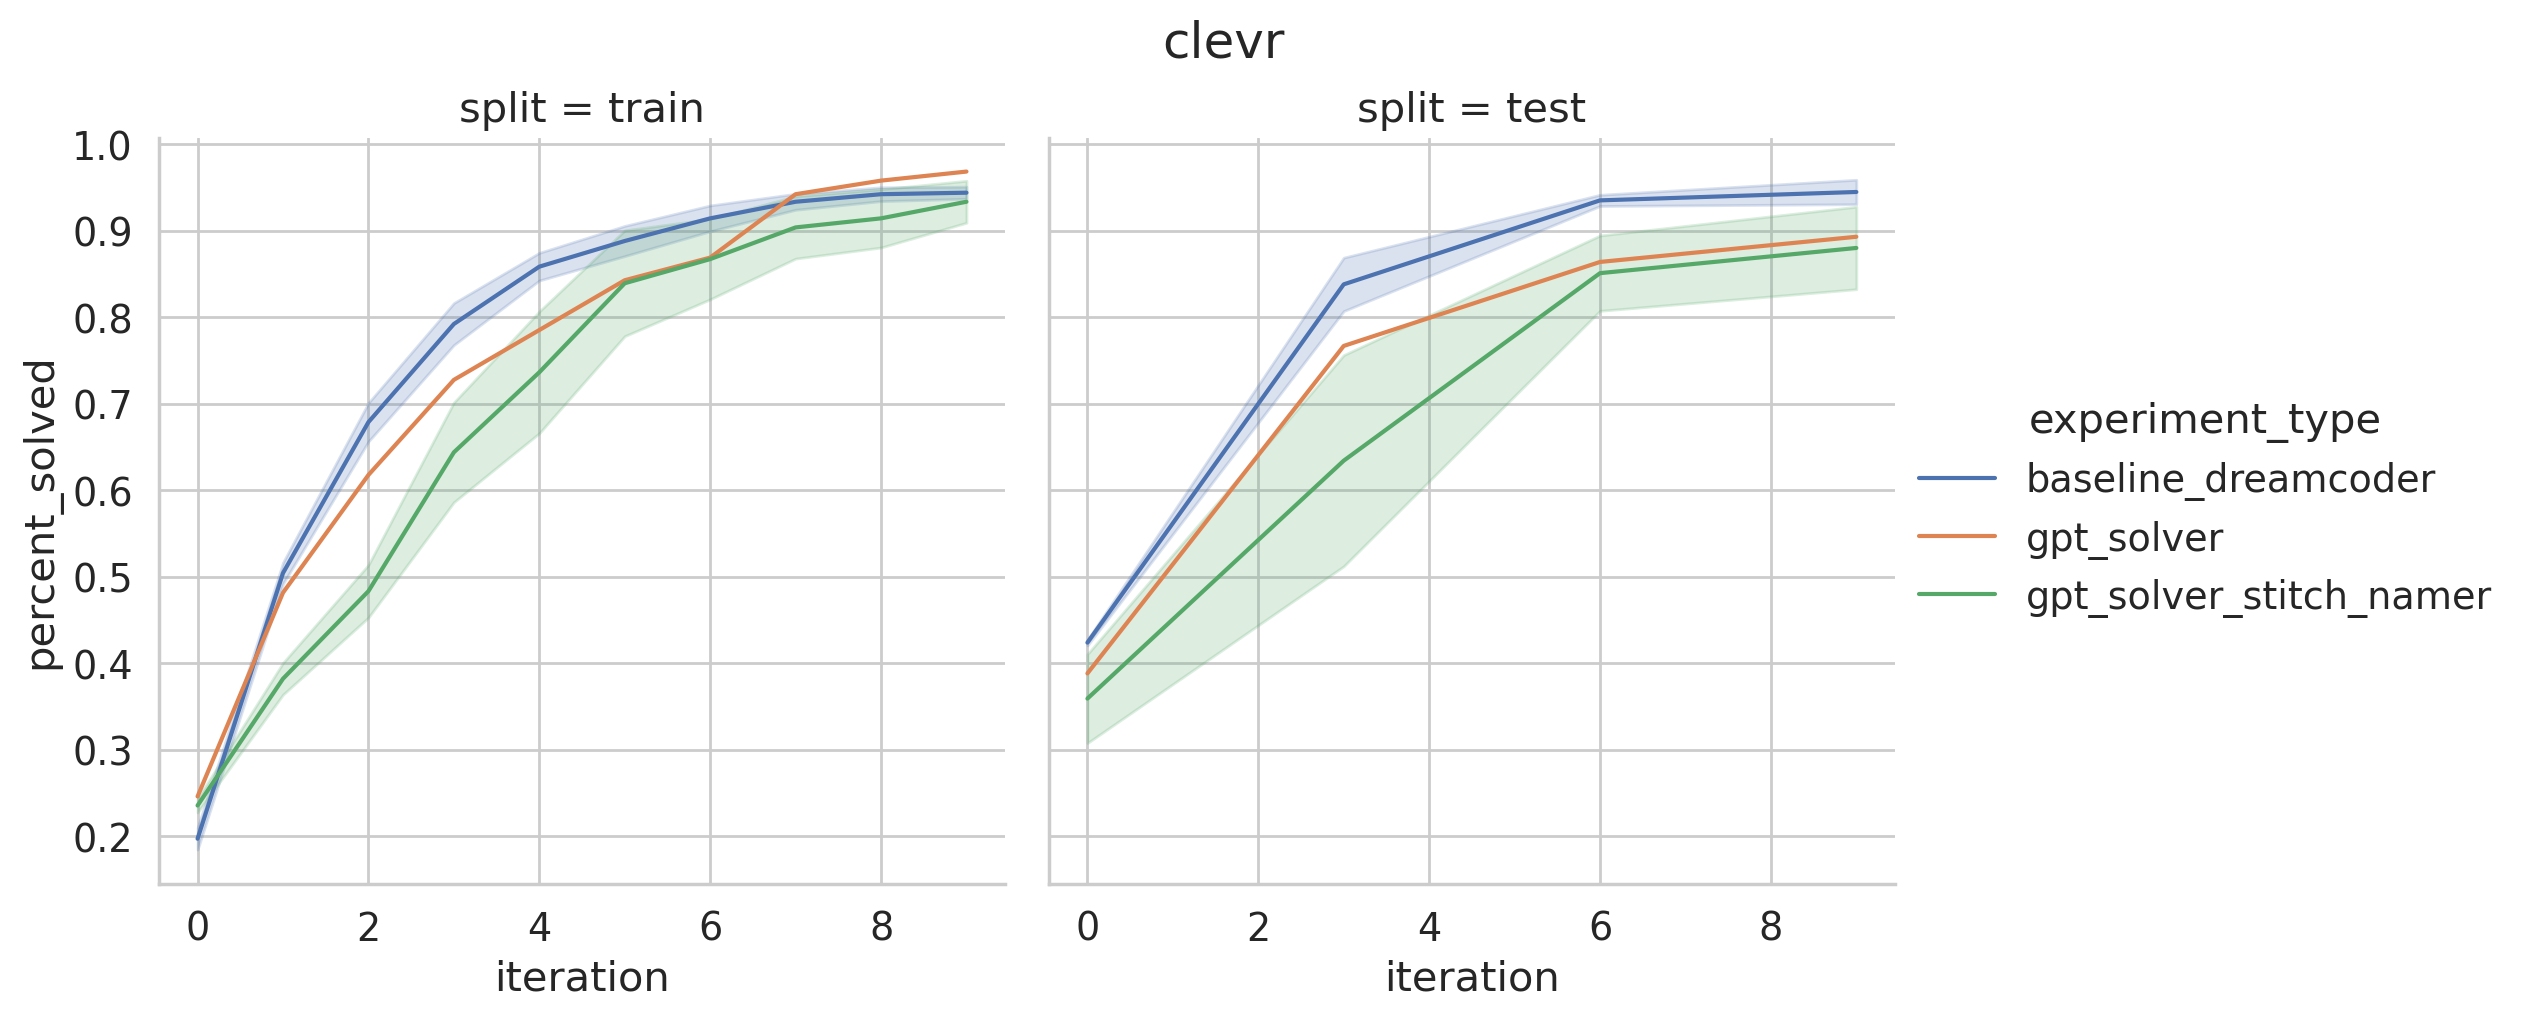

In [39]:
sns.relplot(
    data=df_results,
    kind="line",
    col="split",
    x="iteration", 
    y="percent_solved", 
    hue="experiment_type",
    # style="seed",
    markers=True,
    errorbar="se",
    col_order=["train", "test"],
)
plt.suptitle(f"{DOMAIN}", y=1.025)

### Tasks solved vs. search time

In [30]:
df_search_time = analyzer.get_search_time_results_for_domain(DOMAIN)
df_search_time

ValueError: Enumeration timeouts are inconsistent across conditions: [600, 600, 600, None, None, None, None]

In [ ]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "train"],
    x="time",
    y="n_solved",
    # hue="seed",
    hue="iteration",
    size="iteration",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (train)")

In [ ]:
g = sns.relplot(
    data=df_search_time[df_search_time.split == "train"],
    col="experiment_type",
    x="time",
    y="n_solved",
    hue="iteration",
    size="iteration",
    legend="full",
    kind="line",
    errorbar="se",
)
g.set(xscale='symlog')
plt.suptitle(f"{DOMAIN} (train)")

In [ ]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "test"],
    x="time",
    y="n_solved",
    # hue="seed",
    hue="iteration",
    size="iteration",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (test)")

In [ ]:
g = sns.relplot(
    data=df_search_time[df_search_time.split == "test"],
    col="experiment_type",
    x="time",
    y="n_solved",
    hue="iteration",
    size="iteration",
    legend="full",
    kind="line",
    errorbar="se",
)
g.set(xscale='symlog')
plt.suptitle(f"{DOMAIN} (test)")

# Analysis 2: Library abstractions

In [ ]:
df_abstractions = analyzer.get_abstractions_for_domain(DOMAIN)
df_abstractions.to_csv(f"{DOMAIN}_abstractions.csv", index=False)
df_abstractions

In [ ]:
ax = sns.relplot(data=df_abstractions.query("random_seed == 111").sort_values(by=["dreamcoder"], key=lambda x: x.str.len()), kind="line", col="experiment_type", y="dreamcoder", x="iteration", hue="name", size="name")
ax.set(yticklabels=[])
plt.show()

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(df_abstractions.sort_values(["experiment_type", "random_seed", "name", "iteration"])[["experiment_type", "random_seed", "name", "iteration", "arity", "compression_ratio", "dreamcoder"]])

In [ ]:
sns.lineplot(data=df_abstractions, x="name", y="compression_ratio", size="iteration")

In [ ]:
sns.lineplot(data=df_abstractions, x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.title(f"{DOMAIN} compressivity of library")

In [ ]:
sns.relplot(data=df_abstractions, kind="line", errorbar="se", col="experiment_type", x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.suptitle(f"{DOMAIN} compressivity of library")

# Analysis 3: Solved programs

In [ ]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df.to_csv(f"{DOMAIN}_search_results.csv")

# re2-specific analysis

In [ ]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def task_order(keys):
    return [int(re.split(r'(\d+)', k[len("re2_test_"):])[1]) for k in keys]

def alpha_order(keys):
    return [re.split(r'(\d+)', k[len("re2_test_"):])[-1] for k in keys]

In [ ]:
ITERATION = 6
SEED = 111

df_solved = df.copy()
df_solved = df_solved.query("split == 'test'").query(f"iteration == {ITERATION}").query(f"seed == {SEED}")
df_solved = df_solved[["task", "experiment_type", "solved"]]
df_solved.groupby("experiment_type").sum()

In [ ]:
df_solved

In [ ]:
df_solved_sorted = df_solved[["task", "experiment_type", "solved"]].pivot(index="task", columns=["experiment_type"])
df_solved_sorted = df_solved_sorted.sort_values(by="task", key=task_order)

In [ ]:
def set_color(val):
    return f"color: {'green' if val else 'red'}"

with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    df_display = df_solved_sorted.reset_index(level=0)
    df_display = df_display.style.set_properties(**{'text-align': 'left'}).applymap(set_color)
    display(df_display)

In [ ]:
df_vowel = df[df.task.str.contains("vowel")]
df_vowel = df_vowel.query("experiment_type == 'gpt_solver'").query(f"seed == {SEED}").query(f"iteration == {ITERATION}").query("solved")
df_vowel = df_vowel.sort_values(by="task", key=task_order)

In [ ]:
df_vowel.groupby("split").task.nunique()

In [ ]:
for _, row in df_vowel.iterrows():
    print(row.task)
    for p_data in row.programs:
        print(p_data["program"])
    print()